In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!nvidia-smi

Wed Mar 31 13:58:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import re
import matplotlib.pyplot as plt

In [4]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models, layers

## 1. Data Download
- Train: 150000
- Test: 50000

In [5]:
tr_url = 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt'
te_url = 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt'

path_to_train_file = keras.utils.get_file('train.txt' , tr_url)
path_to_test_file = keras.utils.get_file('test.txt' , te_url)

4898816/4893335 [==============================] - 0s 0us/step


### 1) 'X' Data
- 각 열은 Tab으로 구분
- '0': 부정 / '1': 긍정

In [6]:
train_text = open(path_to_train_file, 'rb').read().decode(encoding = 'utf8')
test_text = open(path_to_test_file, 'rb').read().decode(encoding = 'utf8')

print('Length of train text: {} characters' .format(len(train_text)))
print('Length of test text: {} characters' .format(len(test_text)))
print()
print(train_text[:300])

Length of train text: 6937271 characters
Length of test text: 2318260 characters

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의


### 2) 'y' Label
- 각 문장을 '\n'으로 분리 후 3열(index번호 2)의 값을 정수로 추출

In [7]:
y_train = np.array([[int(row.split('\t')[-1])] for row in train_text.split('\n')[1:]
                    if row.count('\t') > 0])
y_test = np.array([[int(row.split('\t')[-1])] for row in test_text.split('\n')[1:]
                  if row.count('\t') > 0])

y_train.shape, y_test.shape

((150000, 1), (50000, 1))

In [8]:
y_test[:5]

array([[1],
       [0],
       [0],
       [0],
       [0]])

## 2. Data Cleansing

### 1) 'X' Data Cleansing

In [9]:
def clean(string) :
  string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]" , " " , string)
  string = re.sub(r"\'s" , " \'s" , string)
  string = re.sub(r"\'ve" , " \'ve" , string)
  string = re.sub(r"n\'t" , " n\'t" , string)
  string = re.sub(r"\'re" , " \'re" , string)
  string = re.sub(r"\'d" , " \'d" , string)
  string = re.sub(r"\'ll" , " \'ll" , string)

  string = re.sub(r"," , " , " , string)
  string = re.sub(r"!" , " ! " , string)
  string = re.sub(r"\(" , " \( " , string)
  string = re.sub(r"\)" , " \) " , string)
  string = re.sub(r"\?" , " \? " , string)
  
  string = re.sub(r"\s{2,}" , " " , string)
  string = re.sub(r"\'{2,}" , "\'" , string)
  string = re.sub(r"\'" , "" , string)

  return string.lower()

In [10]:
X_train_text = [ row.split('\t')[1] for row in train_text.split('\n')[1:]
                if row.count('\t') > 0]
X_train_text = [ clean(sentence) for sentence in X_train_text ]

In [11]:
sentences = [sentence.split(' ') for sentence in X_train_text]

In [12]:
for i in range(5) :
  print(sentences[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나']
['너무재밓었다그래서보는것을추천한다']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그의', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨에서', '늙어보이기만', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


- 각 문장의 단어길이 시각화

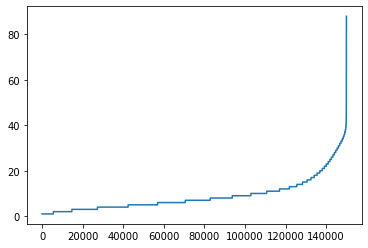

In [13]:
sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()

plt.plot(sentence_len)
plt.show()

In [14]:
sentences_new = []

for sentence in sentences:
  sentences_new.append([word for word in sentence][:40])

sentences = sentences_new

for i in range(5) :
  print(sentences[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나']
['너무재밓었다그래서보는것을추천한다']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그의', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨에서', '늙어보이기만', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


## 3. 'tokenizer()' and 'pad_sequences()'

### 1) 20000개 단어 사용

In [15]:
tokenizer = Tokenizer(num_words = 20000)
tokenizer.fit_on_texts(sentences)

X_train = tokenizer.texts_to_sequences(sentences)
X_train = pad_sequences(X_train, padding = 'post')

print(X_train[:5])

[[   26   897     8  6747  1094     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [  591  5845  6748     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [   73   350    31    36 10467     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [  

### 2) tokenizer() 동작 확인
- 존재하는 단어 매핑

In [16]:
print(tokenizer.index_word[19998] , tokenizer.index_word[1996])

개떡같은 보았는데


In [17]:
temp = tokenizer.texts_to_sequences(['dslkjfsl' , '개떡같은' , '보았는데' , '연기가'])

In [18]:
print(temp)

[[], [19998], [1996], [107]]


In [19]:
temp = pad_sequences(temp, padding = 'post')
print(temp)

[[    0]
 [19998]
 [ 1996]
 [  107]]


## 4. Modeling

### 1) Model Structure

In [20]:
model = models.Sequential()

model.add(layers.Embedding(20000, 300, input_length = 40))

model.add(layers.LSTM(32))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation = 'softmax'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           6000000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                42624     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 6,042,690
Trainable params: 6,042,690
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [23]:
%%time

hist = model.fit(X_train, y_train,
                 epochs = 20,
                 batch_size = 128,
                 validation_split = 0.2)

Epoch 1/10
938/938 [==============================] - 106s 81ms/step - loss: 0.6936 - accuracy: 0.5042 - val_loss: 0.6192 - val_accuracy: 0.6920
Epoch 2/10
938/938 [==============================] - 75s 80ms/step - loss: 0.6197 - accuracy: 0.6873 - val_loss: 0.6176 - val_accuracy: 0.6756
Epoch 3/10
938/938 [==============================] - 74s 79ms/step - loss: 0.6200 - accuracy: 0.6720 - val_loss: 0.6132 - val_accuracy: 0.6611
Epoch 4/10
938/938 [==============================] - 74s 79ms/step - loss: 0.6060 - accuracy: 0.6749 - val_loss: 0.5839 - val_accuracy: 0.7106
Epoch 5/10
938/938 [==============================] - 75s 80ms/step - loss: 0.5681 - accuracy: 0.7355 - val_loss: 0.5455 - val_accuracy: 0.7643
Epoch 6/10
938/938 [==============================] - 75s 80ms/step - loss: 0.5164 - accuracy: 0.7806 - val_loss: 0.4744 - val_accuracy: 0.7804
Epoch 7/10
938/938 [==============================] - 75s 80ms/step - loss: 0.4320 - accuracy: 0.8114 - val_loss: 0.4159 - val_accuracy

### 2) Visualization

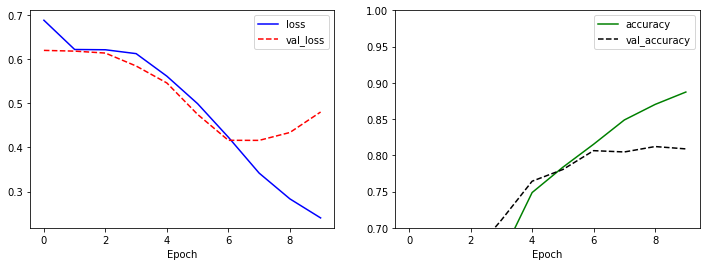

In [24]:
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'] , 'b-' , label = 'loss')
plt.plot(hist.history['val_loss'] , 'r--' , label = 'val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'] , 'g-' , label = 'accuracy')
plt.plot(hist.history['val_accuracy'] , 'k--' , label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

## 5. Validation

In [25]:
X_test_text = [ row.split('\t')[1] for row in test_text.split('\n')[1:]
               if row.count('\t') > 0]
X_test_text = [ clean(sentence) for sentence in X_test_text]

In [26]:
test_sentences = [sentence.split(' ') for sentence in X_test_text]

test_sentences_new = []

for sentence in test_sentences :
  test_sentences_new.append([word for word in sentence][:40])
test_sentences = test_sentences_new

X_test = tokenizer.texts_to_sequences(test_sentences)
X_test = pad_sequences(X_test, padding = 'post')

In [27]:
model.evaluate(X_test, y_test, verbose = 0)

[0.4927098751068115, 0.8006600141525269]

## 6. 문장 감성 분석

- 입력 단어에 따라 감성 분석 결과 변화
  - 긍정('1') -> 부정('0')

In [36]:
test_sentence = '재미있을 줄 알았는데 완전 실망했다. 너무 졸리고 돈이 아까웠다.'

test_sentence = test_sentence.split(' ')

test = []
now_sentence = []

for word in test_sentence:
  now_sentence.append(word)
  test.append(now_sentence[:])

X_test_1 = tokenizer.texts_to_sequences(test)
X_test_1 = pad_sequences(X_test_1, padding = 'post' , maxlen = 40)
prediction = model.predict(X_test_1)

for idx, sentence in enumerate(test) :
  print(sentence)
  print(prediction[idx])

['재미있을']
[0.6130217 0.3869783]
['재미있을', '줄']
[0.56506336 0.43493664]
['재미있을', '줄', '알았는데']
[0.38659674 0.6134032 ]
['재미있을', '줄', '알았는데', '완전']
[0.3947356  0.60526437]
['재미있을', '줄', '알았는데', '완전', '실망했다.']
[0.3947356  0.60526437]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무']
[0.5361149  0.46388513]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고']
[0.9879538  0.01204626]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고', '돈이']
[0.99895394 0.00104603]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고', '돈이', '아까웠다.']
[0.99895394 0.00104603]
